# Detecting Fraud Rings using a Link Prediction Metric

**Approach: Narrow the circle and detect members** 
- Delete low-degree nodes
- Using FxG score, get a subgraph of suspected nodes, thus narrowing the circle
- Fraud Ring members support each other, so get a subgraph of suspected nodes with positive edges
- Detect communities, check if those communities are fraud rings by checking whether each member is a fraudster node

FxG score yields the least error on this data set as a link predictor but we won't use it in its original purpose (See Kumar, 2016)

## Data Preprocessing

In [1]:
# Assigning fairness and goodness as attributes to nodes before island method
from sna_bitcoin_otc.utils.network import get_driver, neo4j_to_nx
from sna_bitcoin_otc.utils.algorithms import fairness_goodness
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

driver = get_driver("bolt://localhost:11012")

G_ = neo4j_to_nx(driver)

fairness, goodness = fairness_goodness(G_)

nx.set_node_attributes(G_, fairness, "fairness")
nx.set_node_attributes(G_, goodness, "goodness")

In [2]:
# Assigning FxG scores as edge attributes

scale = 10

FxG = {}
for e in G_.edges():
    FxG[e] = fairness[e[0]] * goodness[e[1]] * scale

nx.set_edge_attributes(G_, FxG, "FxG_score")

### Island method and other techniques: Getting rid of insignificant nodes/edges

There are lots of nodes with in_degree <=1, we're not interested in them since those nodes can't be fraud ring members

But there's a chance that these nodes may help their fraud rings by giving positive scores.

So, **get nodes with in_degree > 1 or (in_degree >= 1 and out_degree > 1)**

In [3]:
# Island method
query="""MATCH (n:BTCUser)
WITH n, apoc.node.degree.in(n) AS in_degree, apoc.node.degree.out(n) AS out_degree
WHERE in_degree > 1 OR (in_degree >= 1 AND out_degree > 1)
RETURN n.node_id"""

s = driver.session()
island_nodes = [list(record)[0] for record in s.run(query)]

G = G_.subgraph(island_nodes)

count    3554.000000
mean        4.635059
std        13.360591
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       310.000000
dtype: float64


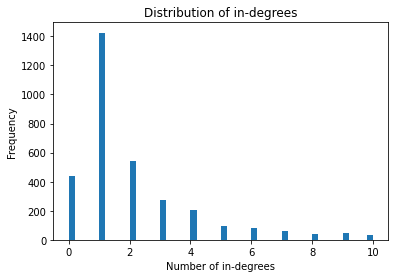

In [4]:
in_degrees = [G.in_degree(node) for node in G.nodes()]

print(pd.Series(in_degrees).describe())

plt.title("Distribution of in-degrees")
plt.xlabel("Number of in-degrees")
plt.ylabel("Frequency")
plt.hist(in_degrees, bins=50, range=(0, 10))
plt.show()

In [5]:
# Getting rid of isolated nodes as well
not_isolated = [node for node in G.nodes() if (G.in_degree(node) + G.out_degree(node)) != 0]
G = G.subgraph(not_isolated)

count    3159.000000
mean       10.429250
std        30.228316
min         1.000000
25%         2.000000
50%         3.000000
75%         8.000000
max       770.000000
dtype: float64


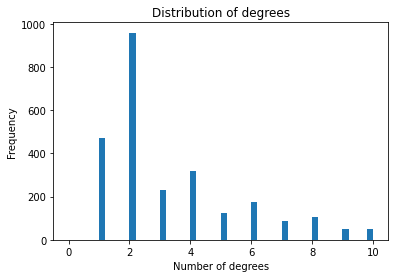

In [6]:
degrees = [G.degree(node) for node in G.nodes()]

print(pd.Series(degrees).describe())

plt.clf()
plt.title("Distribution of degrees")
plt.xlabel("Number of degrees")
plt.ylabel("Frequency")
plt.hist(degrees, bins=50, range=(0, 10))
plt.show()

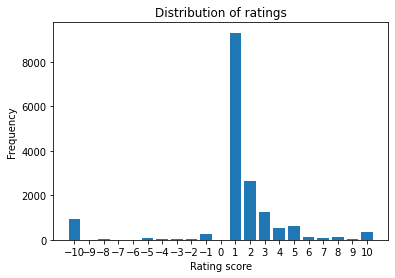

In [7]:
# Distribution of ratings

ratings = [e[2] for e in G.edges(data="weight")]
counts = dict(pd.Series(ratings).value_counts())
counts = dict(sorted(counts.items()))

plt.bar(counts.keys(), counts.values())
plt.xticks([*range(-10, 11)])
plt.title("Distribution of ratings")
plt.xlabel("Rating score")
plt.ylabel("Frequency")
plt.show()

In [8]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 3159
Number of edges: 16473
Average in degree:   5.2146
Average out degree:   5.2146


Market's voting habits and degree structure aren't affected, and we managed to eliminate some nodes (5881 to 3159)

### Identifying possible fraud ring members

Fraud rings consist of fraudster nodes, so why not find and label fraudster individuals with a tendency to become a fraud ring member first?

Goodness and fairness help us, but we can find and utilize time-based patterns as well

To make use of the timestamps, BIRDNEST algorithm calculates **normality**. Normality is a metric to detect fraudulent ratings. BIRDNEST relies on two observations: 1) Fraudulent ratings occur in short bursts of time; 2) Fraudulent users have skewed rating distributions.

*However, due to the approaching deadline and my humanly constraints, I won't use BIRDNEST . The inter-arrival time of ratings and skewness of rating distributions will be calculated for each user here if someone wants to implement BIRDNEST on them. My brain is not able to process BIRDNEST right now.*

*ps: Go down and see my solution performing better than BIRDNEST in the supervised case :)*

### Inter-arrival time and skewed rating distributions

In [9]:
# Inter-arrival times (in seconds)
from sna_bitcoin_otc.utils.network import get_dataframe

df = get_dataframe()

iat = {}

for node in G_.nodes():
    ratings = df[df["src_id"] == node]
    timestamps = list(ratings["timestamp"])
    iat[node] = []
    if not timestamps:
        continue
    for i in range(1, len(timestamps)):
        iat[node].append((timestamps[i] - timestamps[i - 1]))
        
iat_values = [*iat.values()]
iat_values = [int(item) for sublist in iat_values for item in sublist]

print(pd.Series(iat_values).describe())

count    3.068400e+04
mean     1.579079e+06
std      5.362963e+06
min      0.000000e+00
25%      1.069700e+04
50%      1.600675e+05
75%      7.959670e+05
max      1.120633e+08
dtype: float64


count    5881.000000
mean        0.945258
std         0.184674
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
1.000000    5004
0.000000     135
0.500000      87
0.750000      62
0.666667      40
            ... 
0.977273       1
0.840000       1
0.992063       1
0.943396       1
0.700000       1
Length: 216, dtype: int64


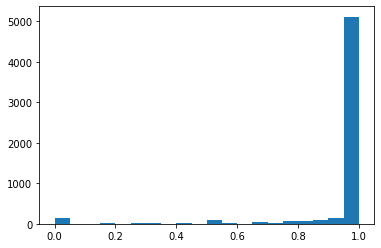

In [10]:
# Inter-arrival times
# IAT <= 5 mins are considered suspected
# Time-based trustworthiness of a user: 1 - (Number of suspected ratings / Number of all ratings) 
    # Range: [0, 1]
    # Users who hasn't rated anyone -> 1 

sus_threshold = 300
trust_iat = {}

for node in G_.nodes():
    num_ratings = len(iat[node])
    if num_ratings == 0:
        trust_iat[node] = 1
        continue
    sus = sum([node_iat <= sus_threshold for node_iat in iat[node]])
    trust_iat[node] = 1 - (sus / num_ratings)

print(pd.Series(list(trust_iat.values())).describe())
print(pd.Series(list(trust_iat.values())).value_counts())

plt.hist(list(trust_iat.values()), bins=20)
plt.show()

Suspecting of nodes with IAT Trustworthiness < 1 looks very distinctive here

count    5881.000000
mean        0.943812
std         0.188592
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
1.000000    4986
0.000000     157
0.500000      84
0.666667      60
0.750000      45
            ... 
0.785714       1
0.962025       1
0.897959       1
0.125000       1
0.920000       1
Length: 197, dtype: int64


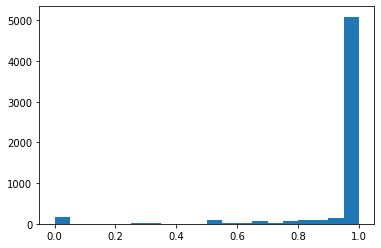

In [11]:
# Non-extremity
# An extreme rating is a +10 or -10
# Non-extremity trustworthiness of a user: 1 - (Number of extreme ratings / Number of all ratings)
    # Range: [0, 1]
    # Users with hasn't rated anyone -> 1
    
trust_ext = {}
extremes = (10, -10)

for node in G_.nodes():
    ratings = list(df[df["src_id"] == node]["rating"])
    num_ratings = len(ratings)
    if num_ratings == 0:
        trust_ext[node] = 1
        continue
    sus = sum([r in extremes for r in ratings])
    trust_ext[node] = 1 - (sus / num_ratings)

print(pd.Series(list(trust_ext.values())).describe())
print(pd.Series(list(trust_ext.values())).value_counts())

plt.hist(list(trust_ext.values()), bins=20)
plt.show()

Suspecting of nodes with non-extremity Trustworthiness < 1 looks very distinctive here too

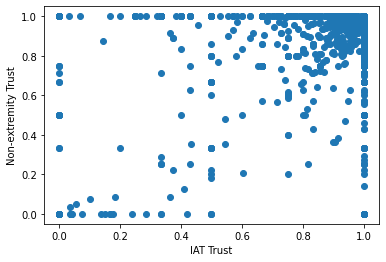

In [12]:
# Plotting IAT trust and non-extremity trust together
plt.scatter(list(trust_iat.values()), list(trust_ext.values()))
plt.xlabel("IAT Trust")
plt.ylabel("Non-extremity Trust")
plt.show()

### Getting suspected nodes 

Now that we know where to look at to get suspected nodes, let's just get them

Condition: A fraud ring member is involved in unfair edges either to attack someone's reputation or to protect their friends' reputation

count    16473.000000
mean         6.820211
std         19.803863
min          0.000000
25%          0.076417
50%          0.487288
75%          2.435715
max        244.438840
dtype: float64


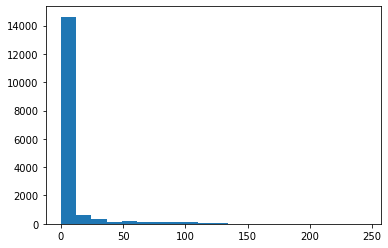

In [13]:
# Heuristic: Declare edges with err > mean + 1std as suspected, change the threshold according to the performance

err = []
sus_edges = []
sus_threshold = 26.62
for edge in G.edges(data="weight"):
    err.append(abs(FxG[(edge[0], edge[1])] - edge[2]) ** 2)
    if err[-1] > sus_threshold:
        sus_edges.append((edge[0], edge[1]))
sus_edges = list(set(sus_edges))
        
    
print(pd.Series(err).describe())
    
# Distribution of root mean sq error
plt.hist(err, bins=20)
plt.show()

In [14]:
sus_nodes = []
for e in sus_edges:
    sus_nodes.append(e[0])
    sus_nodes.append(e[1])
sus_nodes = list(set(sus_nodes))

In [15]:
G_sus = G.edge_subgraph(sus_edges)

In [16]:
degrees_sus = [G_sus.degree(node) for node in G_sus.nodes()]

print(pd.Series(degrees_sus).describe())

count    732.000000
mean       3.256831
std        5.613365
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       83.000000
dtype: float64


In [17]:
print(nx.info(G_sus))

Name: 
Type: DiGraph
Number of nodes: 732
Number of edges: 1192
Average in degree:   1.6284
Average out degree:   1.6284


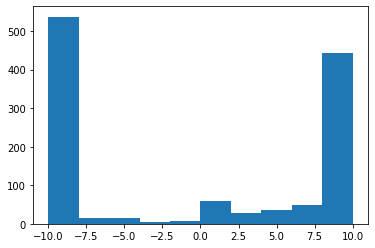

In [18]:
ratings_sus = [edge[2] for edge in G_sus.edges(data="weight")]

plt.hist(ratings_sus, bins=10)
plt.show()

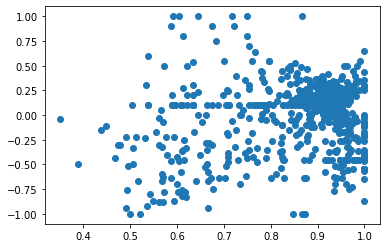

In [19]:
fairness_sus = [fairness[node] for node in G_sus.nodes()]
goodness_sus = [goodness[node] for node in G_sus.nodes()]

plt.scatter(fairness_sus, goodness_sus)
plt.show()

**Visualizing the suspected edges**

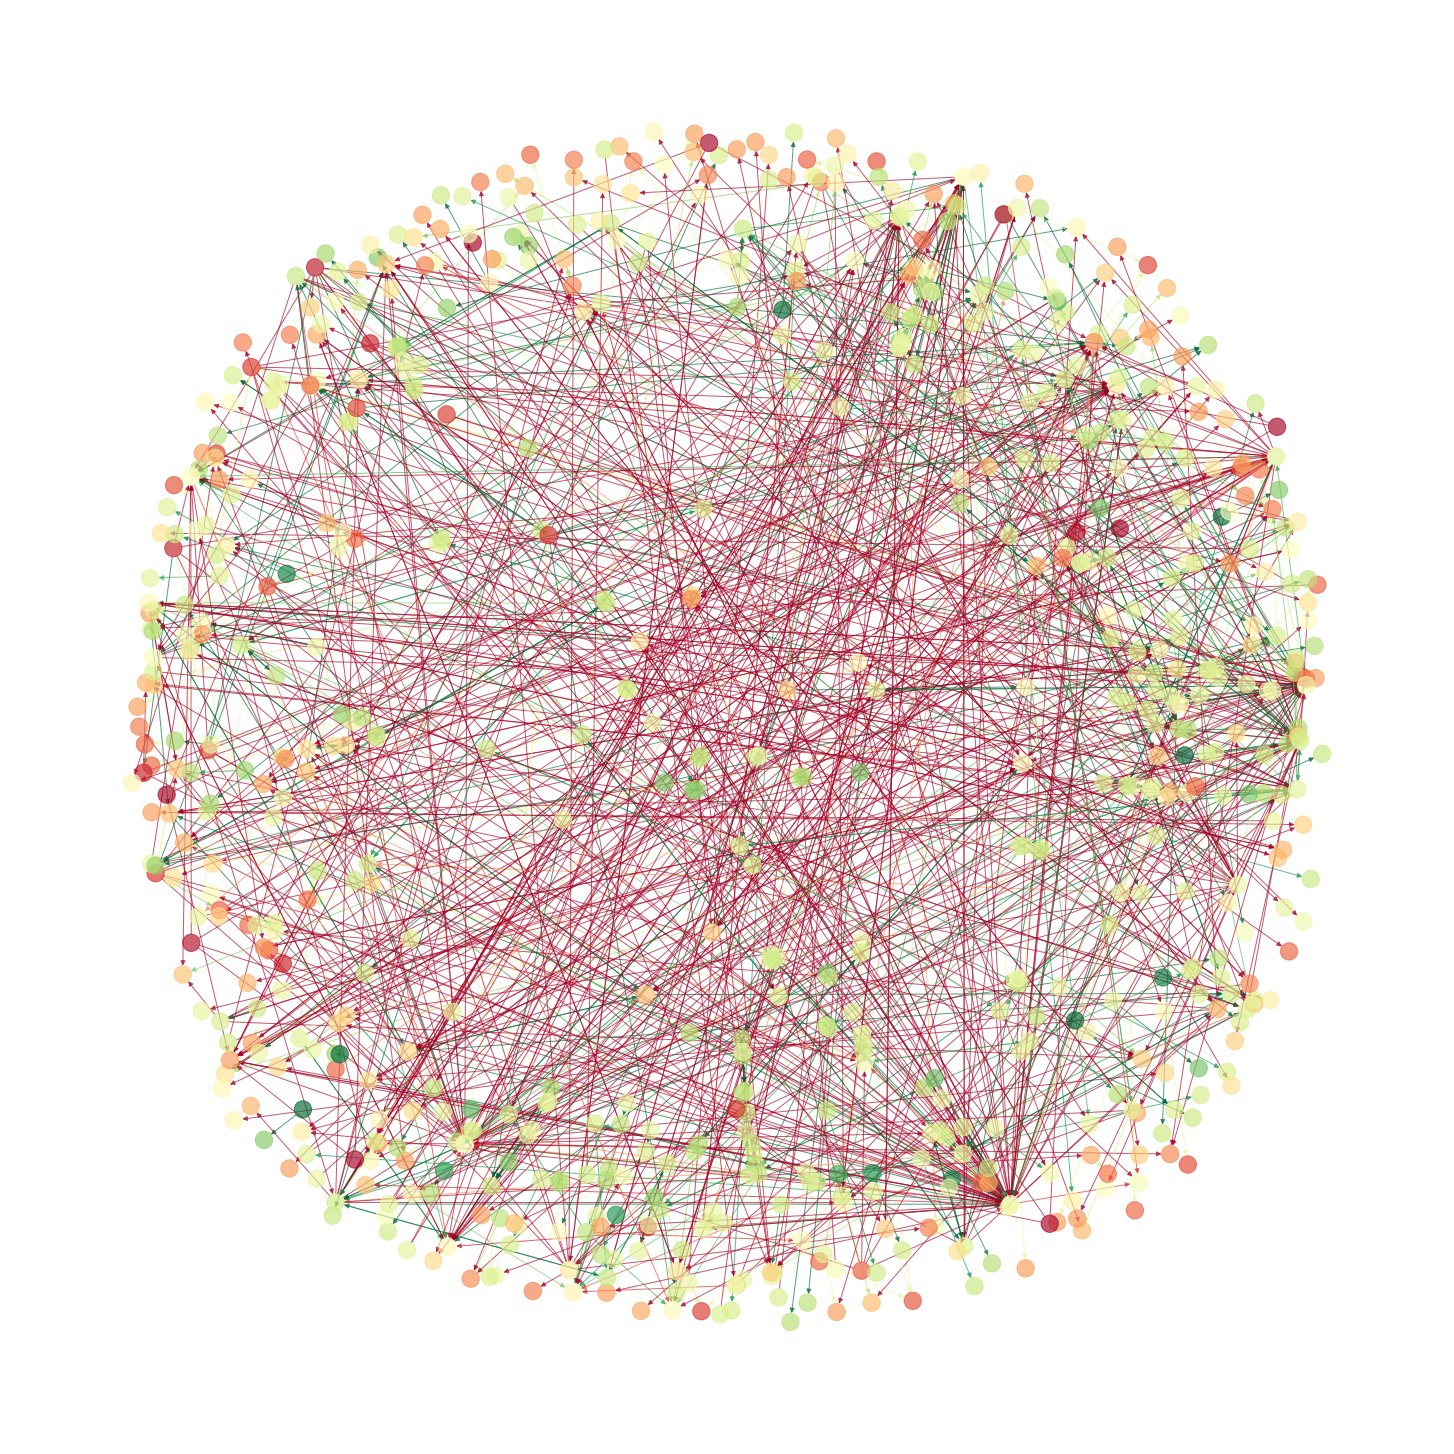

In [20]:
from matplotlib import cm
rdylgn = cm.get_cmap("RdYlGn")

plt.figure(figsize=(20, 20))
sus_weights_scaled = [e[2] / 10 for e in G_sus.edges(data="weight")]
goodness_sus_scaled = [(g + 1) / 2 for g in goodness_sus]
nx.draw(G_sus, node_color=goodness_sus_scaled, cmap="RdYlGn", 
        edge_color=sus_weights_scaled, edge_cmap=rdylgn, alpha=0.65,
       vmin=0, vmax=1, edge_vmin=-1, edge_vmax=1)
plt.show()

We were able to shrink the graph to 732 nodes and 1192 edges.

In [21]:
# We expect fraud ring members to support each other. So let's get a subgraph of G_sus with only positive edges

sus_edges_pos = [(e[0], e[1]) for e in G_sus.edges(data="weight") if e[2] > 0]

G_sus_pos = G.edge_subgraph(sus_edges_pos)

In [22]:
print(nx.info(G_sus_pos))

Name: 
Type: DiGraph
Number of nodes: 543
Number of edges: 615
Average in degree:   1.1326
Average out degree:   1.1326


**Visualizing positive suspected edges**

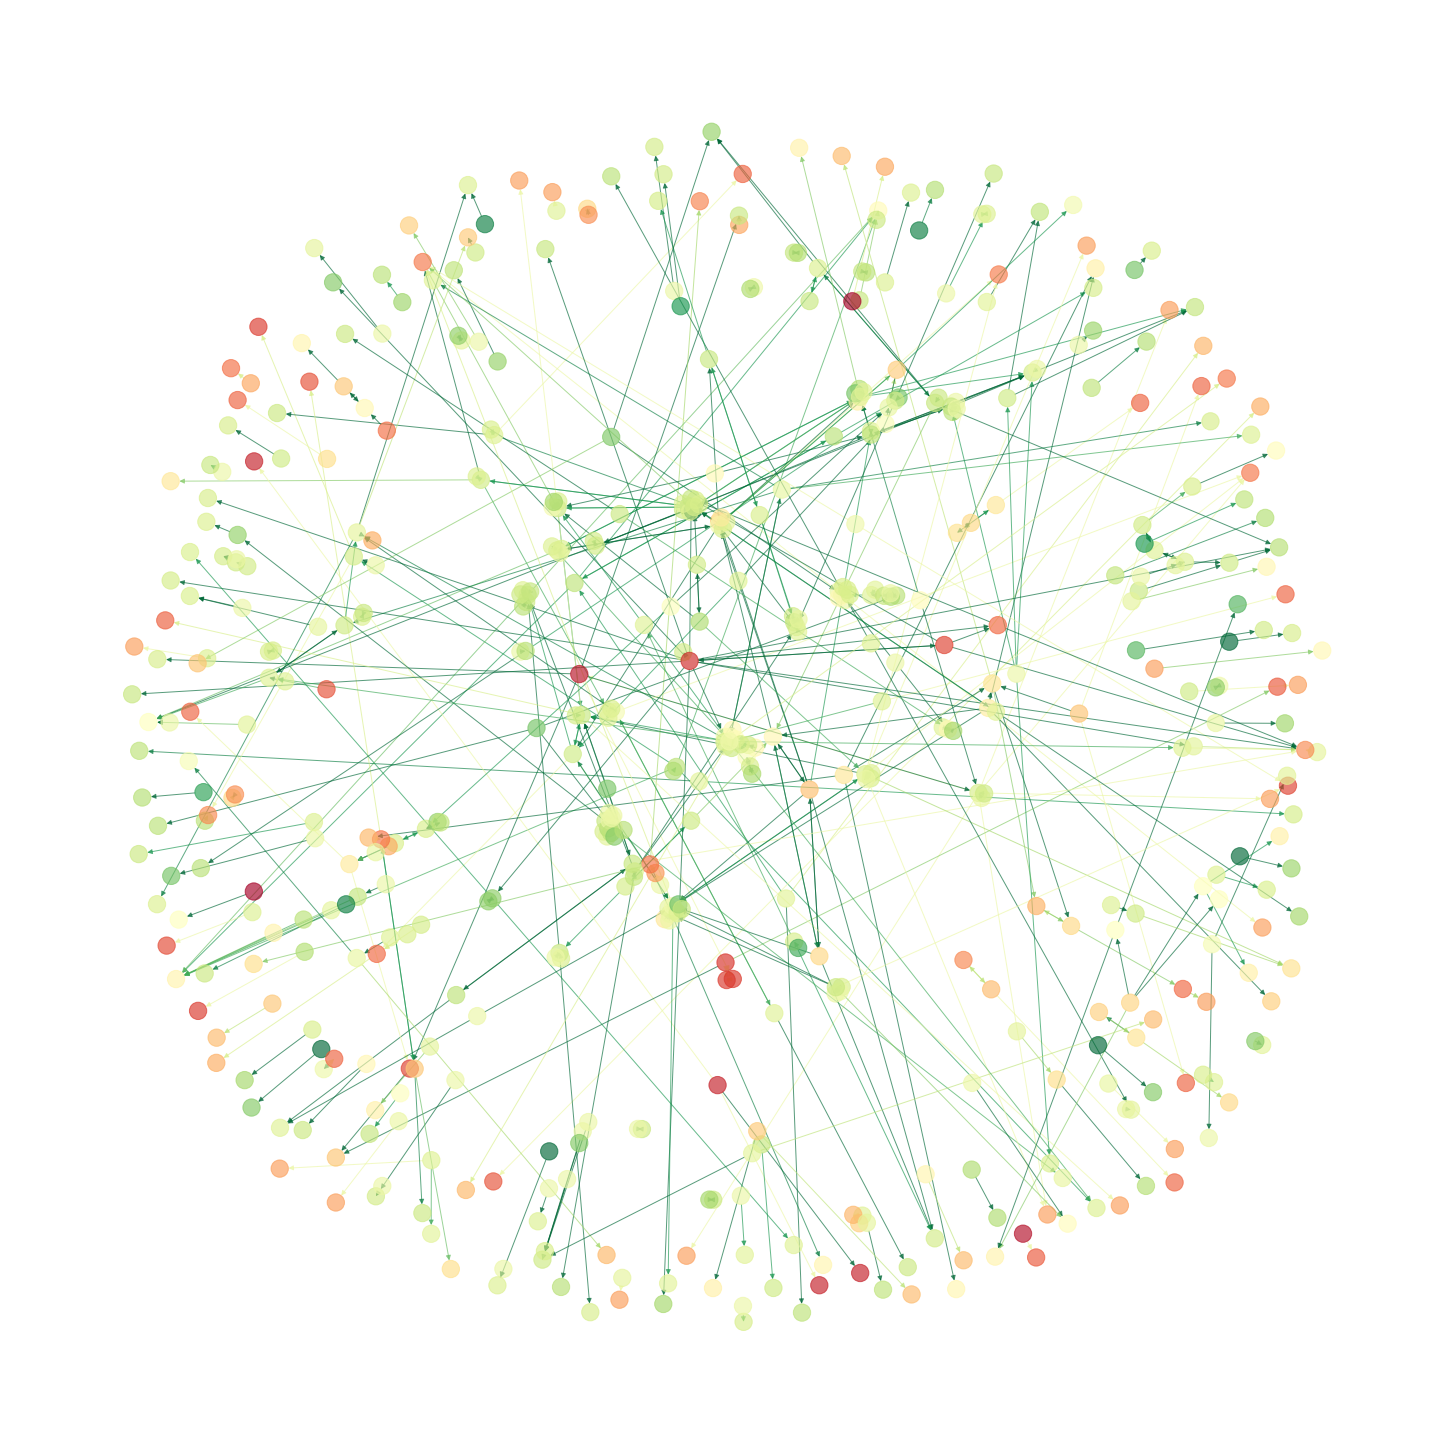

In [23]:
rdylgn = cm.get_cmap("RdYlGn")

goodness_sus_pos = [goodness[node] for node in G_sus_pos.nodes()]

plt.figure(figsize=(20, 20))
sus_weights_pos_scaled = [e[2] / 10 for e in G_sus_pos.edges(data="weight")]
goodness_sus_pos_scaled = [(g + 1) / 2 for g in goodness_sus_pos]
nx.draw(G_sus_pos, node_color=goodness_sus_pos_scaled, cmap="RdYlGn", 
        edge_color=sus_weights_pos_scaled, edge_cmap=rdylgn, alpha=0.65,
       vmin=0, vmax=1, edge_vmin=-1, edge_vmax=1, label=True)
plt.show()

## Detecting communities

In [24]:
import community as community_louvain

G_sus_pos_undir = G_sus_pos.to_undirected()

louvain = community_louvain.best_partition(G_sus_pos_undir)

communities_nodes = {}
for node, comm in louvain.items():
    if comm not in communities_nodes:
        communities_nodes[comm] = []
    communities_nodes[comm].append(node)
communities_nodes

{0: [1,
  2,
  3,
  6,
  10,
  13,
  29,
  32,
  44,
  95,
  139,
  159,
  163,
  165,
  178,
  197,
  217,
  228,
  243,
  244,
  270,
  273,
  278,
  375,
  425,
  432,
  494,
  4922,
  841,
  865,
  894,
  1057,
  1084,
  1166,
  1513],
 1: [4101, 4116],
 3: [5, 2140, 815],
 4: [2062,
  26,
  4264,
  2387,
  4522,
  2561,
  2670,
  2710,
  2839,
  3110,
  3230,
  5339,
  3383,
  3414,
  3540,
  3924],
 5: [17,
  45,
  75,
  428,
  526,
  535,
  680,
  729,
  734,
  1053,
  1176,
  1227,
  1312,
  1394,
  1507,
  1623,
  1746],
 6: [4115,
  4434,
  4443,
  4519,
  4524,
  4557,
  4571,
  4588,
  4591,
  4592,
  4598,
  4618,
  4643,
  4706,
  4714,
  3168,
  5550,
  3759,
  3797],
 7: [21,
  2125,
  105,
  2388,
  408,
  453,
  495,
  2876,
  862,
  3335,
  3660,
  3668,
  1624,
  3681,
  3683,
  1697,
  1921,
  1966,
  1970],
 8: [2070, 2080],
 9: [2079,
  4135,
  4335,
  4427,
  4457,
  4523,
  4541,
  4655,
  2707,
  2884,
  977,
  3093,
  3129,
  1310,
  3363,
  1492,
  3628,
  3

In [25]:
print(pd.Series(list(fairness.values())).describe())
print(pd.Series(list(goodness.values())).describe())

count    5881.000000
mean        0.935009
std         0.089061
min         0.350000
25%         0.925182
50%         0.959269
75%         0.986824
max         1.000000
dtype: float64
count    5881.000000
mean        0.072576
std         0.282187
min        -1.000000
25%         0.100000
50%         0.100000
75%         0.168750
max         1.000000
dtype: float64


In [26]:
iat_sus_pos = {node: trust_iat[node] for node in G_sus_pos.nodes()}

print(pd.Series(list(iat_sus_pos.values())).describe())
print(pd.Series(list(trust_iat.values())).describe())

count    543.000000
mean       0.898242
std        0.244470
min        0.000000
25%        0.981042
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64
count    5881.000000
mean        0.945258
std         0.184674
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Piece of intuition: there should be three types of fraud rings.
- First: Communities supporting bad nodes. May include low IAT trustworthy nodes or not
- Second: Communities with moderate-to-high goodness people just upping their ratings, this is detected with low IAT trust
- Third: A hybrid of First and Second

## Detecting fraudster individuals

We found the communities, we know which metrics to look at, now we only have to build a supervised learning model that predicts whether a node is a fraudster node, using fairness, goodness, and IAT trust.

We will create training data with these axioms (hope we get a good amount of data):
- If founder (id 1) trusts a node (with a rating >= 5), that node is not fraud
- If founder distrusts a node (with a rating <= -5), that node is fraud
- If nodes rated >= 5 by the founder trust/distrust a node, ditto

In [27]:
def get_node_views(_df):
    node_views = []
    for i in range(len(_df)):
        row = _df.iloc[i]
        fraud = None
        if row["rating"] >= 5:
            fraud = False
        elif row["rating"] <= -5:
            fraud = True
        if fraud is not None:
            node_views.append(create_data_row(row["dest_id"], fraud))
    return node_views

def create_data_row(dest_id_, fraud_status):
    dest_id_ = int(dest_id_)
    return {"node": dest_id_, 
            "fairness": 1 if dest_id_ not in fairness else fairness[dest_id_], 
            "goodness": 0 if dest_id_ not in goodness else goodness[dest_id_], 
            "trust_iat": 1 if dest_id_ not in trust_iat else trust_iat[dest_id_],
           "fraud": fraud_status}

founder_ratings = get_node_views(df.loc[df["src_id"] == 1])

founder_trusts = list(df.loc[(df["src_id"] == 1) & (df["rating"] >= 5)]["dest_id"])

trusted_ratings = []
for node in founder_trusts:
    trusted_ratings += get_node_views(df.loc[df["src_id"] == node])

fraud_data = founder_ratings + trusted_ratings

In [28]:
fraud_df = pd.DataFrame(fraud_data)
fraud_df.describe()

node    fairness    goodness   trust_iat
count   490.000000  490.000000  490.000000  490.000000
mean   2081.238776    0.930362    0.090931    0.848959
std    1944.609977    0.083975    0.310234    0.245411
min       1.000000    0.409148   -1.000000    0.000000
25%     132.500000    0.914190    0.100000    0.825980
50%    1419.500000    0.950847    0.107143    0.956710
75%    3834.250000    0.975000    0.220000    1.000000
max    5929.000000    1.000000    1.000000    1.000000

In [29]:
fraud_df.head()

node  fairness  goodness  trust_iat  fraud
0    17  0.938704  0.330769   0.840000  False
1     2  1.000000 -0.028571   0.681818  False
2    23  0.914137  0.100000   0.823529  False
3     7  0.972788  0.566667   0.956710  False
4    19  0.932113  0.154545   0.363636  False

In [30]:
print(fraud_df["fraud"].value_counts())

False    273
True     217
Name: fraud, dtype: int64


In [31]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   node       490 non-null    int64  
 1   fairness   490 non-null    float64
 2   goodness   490 non-null    float64
 3   trust_iat  490 non-null    float64
 4   fraud      490 non-null    bool   
dtypes: bool(1), float64(3), int64(1)
memory usage: 15.9 KB


In [32]:
X = fraud_df[["fairness", "goodness", "trust_iat"]]
y = fraud_df["fraud"]

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)

In [83]:
y_hat = logreg.predict_proba(X_test)
# Trying different thresholds
y_04 = [val[1] >= 0.4 for val in y_hat]
y_045 = [val[1] >= 0.45 for val in y_hat]
y_05 = [val[1] >= 0.5 for val in y_hat]


In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_04, y_test))
print(classification_report(y_045, y_test))
print(classification_report(y_05, y_test))

              precision    recall  f1-score   support

       False       0.69      0.72      0.71        69
        True       0.63      0.59      0.61        54

    accuracy                           0.67       123
   macro avg       0.66      0.66      0.66       123
weighted avg       0.67      0.67      0.67       123

              precision    recall  f1-score   support

       False       0.89      0.74      0.81        87
        True       0.55      0.78      0.64        36

    accuracy                           0.75       123
   macro avg       0.72      0.76      0.72       123
weighted avg       0.79      0.75      0.76       123

              precision    recall  f1-score   support

       False       0.93      0.71      0.80        95
        True       0.45      0.82      0.58        28

    accuracy                           0.73       123
   macro avg       0.69      0.76      0.69       123
weighted avg       0.82      0.73      0.75       123



For LogReg - The best threshold is 0.45

In [85]:
# Trying KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(weights="uniform").fit(X_train, y_train)
knn_dist = KNeighborsClassifier(weights="distance").fit(X_train, y_train)

In [86]:
y_hat_knn = knn.predict(X_test)
y_hat_dist = knn_dist.predict(X_test)

In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_hat_knn, y_test))

print(classification_report(y_hat_dist, y_test))

              precision    recall  f1-score   support

       False       0.83      0.81      0.82        74
        True       0.73      0.76      0.74        49

    accuracy                           0.79       123
   macro avg       0.78      0.78      0.78       123
weighted avg       0.79      0.79      0.79       123

              precision    recall  f1-score   support

       False       0.88      0.85      0.86        74
        True       0.78      0.82      0.80        49

    accuracy                           0.84       123
   macro avg       0.83      0.83      0.83       123
weighted avg       0.84      0.84      0.84       123



KNN with weights="distance" is the best so far

In [110]:
# AUC with 10-fold cross validation:
from sklearn.model_selection import cross_val_score
round(np.mean(cross_val_score(knn_dist, X, y, scoring="roc_auc", cv=10)), 2)

0.89

### Comparing the AUC of our individual fraud detector with other well-known algorithms

Data is taken from Kumar, 2018

"For this dataset, in the supervised case, scores are 10-fold AUC scores" 
- REV2: 0.90
- **Our approach: 0.89**
- FraudEagle: 0.89
- Spamicity: 0.88
- Trustiness: 0.82
- BAD (Bias-and-Deserve): 0.79
- SpamBehavior: 0.77
- ICWSM'13: 0.75
- BIRDNEST: 0.71
- SpEagle: 0.69
- SpEagle+: 0.55

## Detecting Fraud Rings
Remember: Fraud rings consist of fraudsters

A community's "fraudster rate": sum(Is_Fraud(node) * Degr(node)) / sum(Degree(node))

In such rings, the influential ones are well-connected ones. Therefore a node's degree is that node's influence in the community.

In [89]:
fraud_detection = KNeighborsClassifier(weights="distance").fit(X, y)

In [97]:
def is_fraudster(node):
    node_fairness = 1 if node not in fairness else fairness[node]
    node_goodness = 0 if node not in goodness else goodness[node]
    node_trust_iat = 1 if node not in trust_iat else trust_iat[node]
    return fraud_detection.predict(np.array([[node_fairness, node_goodness, node_trust_iat]]))[0]

In [112]:
is_fraudster(1)

False

In [113]:
def fraudster_rate(comm_: nx.Graph):
    fraud_deg = 0
    total_deg = 0
    for node in comm_.nodes():
        deg = comm_.degree(node)
        fraud_deg += is_fraudster(node) * deg
        total_deg += deg
    return fraud_deg / total_deg

Calculating fraudster rates of each community

In [119]:
fraudster_rates = {
    comm: (fraudster_rate(G_sus_pos_undir.subgraph(comm_nodes)), len(comm_nodes)) 
    for comm, comm_nodes in communities_nodes.items()
}

In [120]:
fraudster_rates

{0: (0.2361111111111111, 35),
 1: (0.5, 2),
 3: (0.75, 3),
 4: (0.5666666666666667, 16),
 5: (0.14705882352941177, 17),
 6: (0.925, 19),
 7: (0.8333333333333334, 19),
 8: (0.0, 2),
 9: (0.6578947368421053, 19),
 10: (0.5, 2),
 11: (0.4375, 33),
 12: (0.35714285714285715, 8),
 13: (0.8333333333333334, 4),
 14: (0.2777777777777778, 25),
 40: (0.71875, 17),
 17: (0.5, 2),
 18: (0.0, 2),
 19: (0.03571428571428571, 14),
 26: (0.5882352941176471, 33),
 21: (0.0, 3),
 22: (1.0, 2),
 23: (0.5, 2),
 38: (0.4142857142857143, 30),
 25: (0.75, 3),
 27: (0.0, 2),
 28: (0.3333333333333333, 4),
 29: (0.25, 3),
 30: (0.5, 2),
 31: (0.0, 2),
 46: (0.5208333333333334, 22),
 33: (0.5, 2),
 34: (0.0, 2),
 35: (0.5, 2),
 36: (1.0, 2),
 37: (0.0, 2),
 39: (1.0, 3),
 41: (0.9, 6),
 42: (0.0, 2),
 43: (0.5, 2),
 44: (1.0, 3),
 45: (0.9285714285714286, 20),
 47: (0.5, 2),
 48: (0.75, 5),
 49: (1.0, 4),
 50: (0.5, 2),
 51: (0.0, 2),
 52: (1.0, 4),
 53: (1.0, 2),
 54: (0.5, 2),
 55: (1.0, 2),
 56: (0.5, 2),
 57:

**Visualizing some of the biggest fraud rings**

ValueError: 'c' argument has 36 elements, which is inconsistent with 'x' and 'y' with size 35.

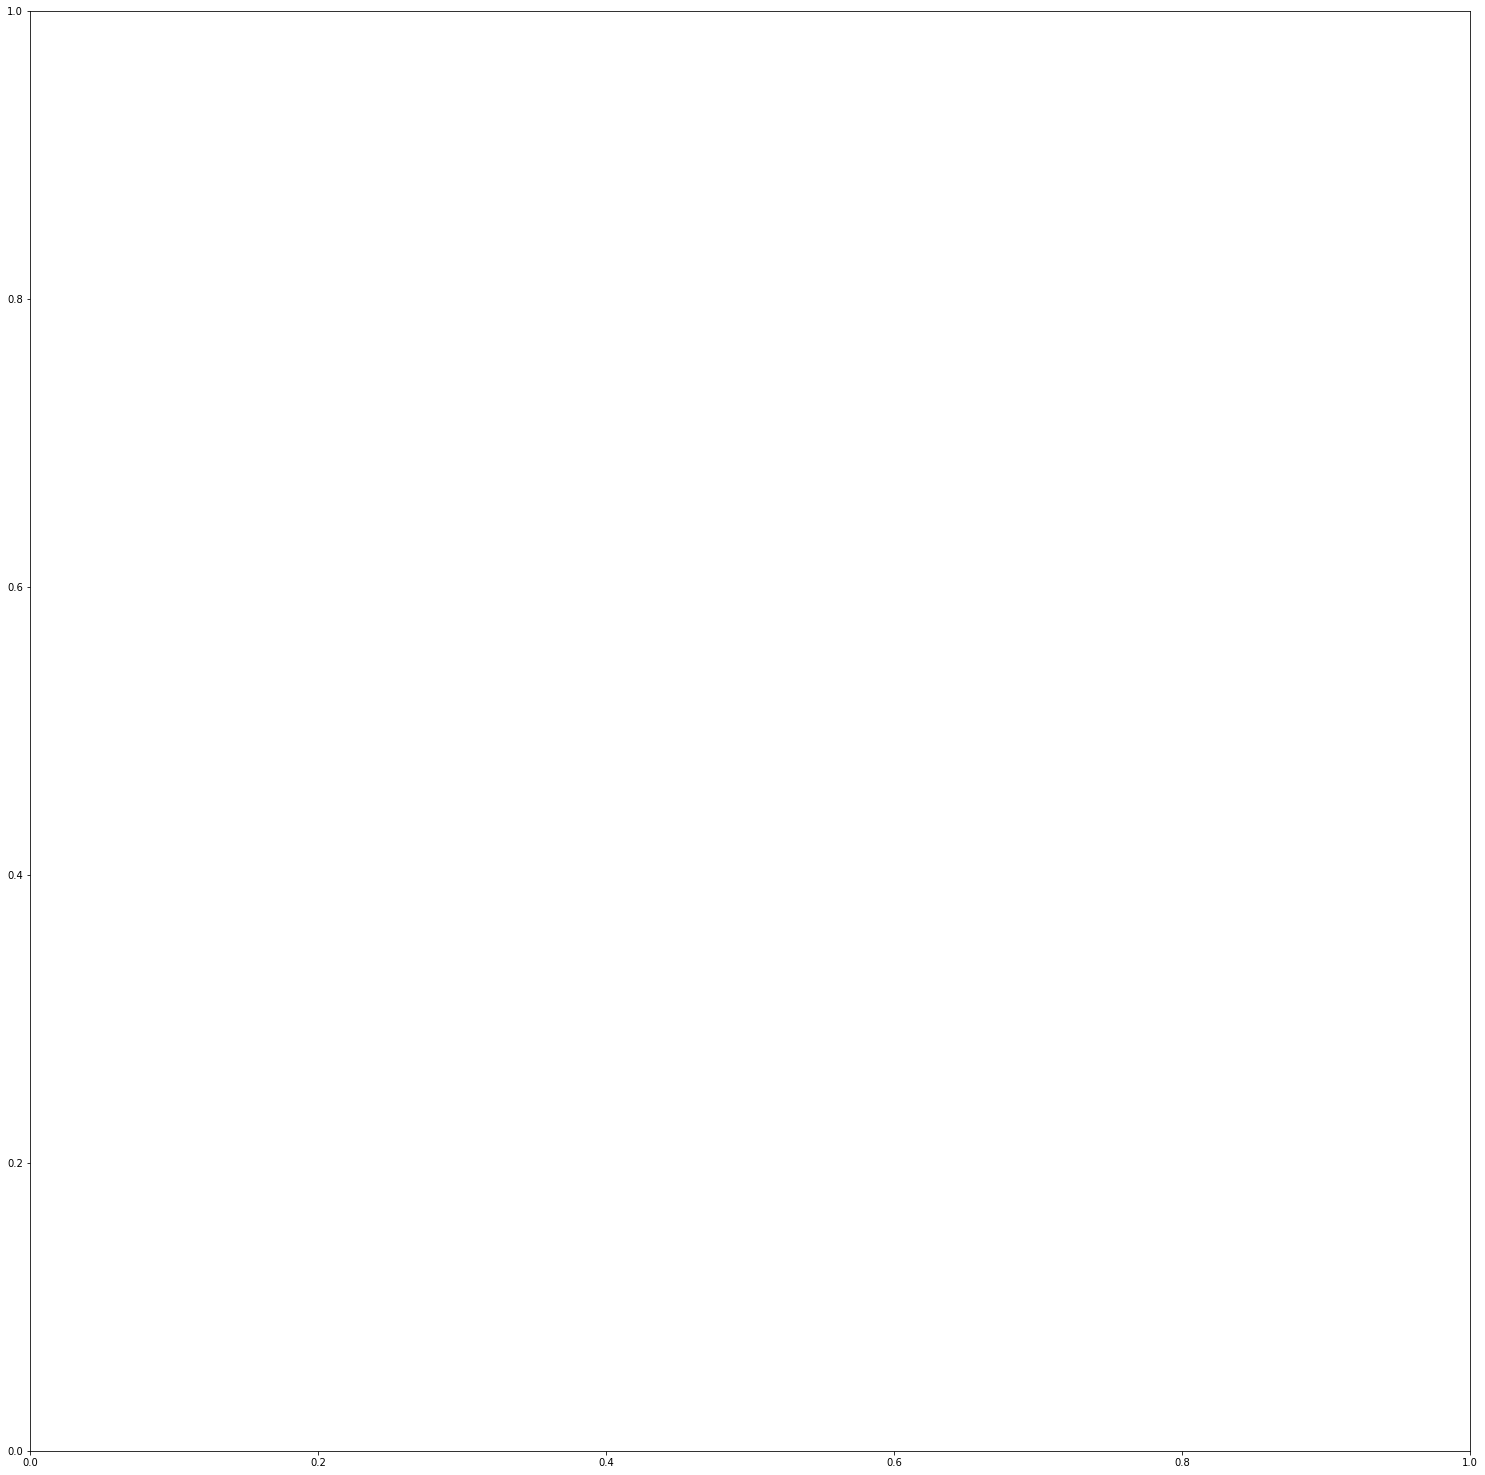

In [131]:
comm_G = G_sus_pos_undir.subgraph(communities_nodes[0])

plt.figure(figsize=(20, 20))
comm_weights_scaled = [e[2] / 10 for e in comm_G.edges(data="weight")]
comm_goodness = [0 if node not in goodness else goodness[node] for node in comm_G.nodes()]
nx.draw(comm_G, node_color=comm_weights_scaled, cmap="RdYlGn", 
        edge_color=comm_goodness, edge_cmap=rdylgn, alpha=0.65, 
        vmin=-1, vmax=1, edge_vmin=-1, edge_vmax=1, label=True)
plt.show()